# Random Sample Data

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.random.rand(500, 4)
y = np.random.rand(500, 3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 4), (100, 4), (400, 3), (100, 3))

# Step 1: Dataset & dataloader

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)

y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [27]:
train_set    = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

test_set     = TensorDataset(X_test, y_test)
test_loader  = DataLoader(test_set, batch_size=32, shuffle=True)

# Step 2 Bangun Arsitektur & config

In [28]:
from torch import nn
from jcopdl.layers import linear_block
#
#def linear_block(n_in, n_out, batch_norm=False, activation='relu', dropout=0.):
#    """
#    available activation {relu, lrelu, sigmoid, tanh, elu, selu, softmax, lsoftmax}
#    """
#    layers = [nn.Linear(n_in, n_out)]
#
#    if batch_norm:
#        layers.append(nn.BatchNorm1d(n_out))
#
#    if activation in _act_func:
#        layers.append(_act_func[activation])
#    else:
#        raise Exception(f"jcopdl supports ({', '.join(_act_func.keys())})")
#
#    if 0 < dropout <= 1:
#        layers.append(nn.Dropout(dropout))
#    return nn.Sequential(*layers)

In [29]:
[i for i in range(5)]

[0, 1, 2, 3, 4]

In [30]:
class customNeuralNetwork(nn.Module):
    def __init__(self, input_Size, n_neuron, output, activation='relu', activation_output='lsoftmax', batch_norm=False, drop=0.2):
        super().__init__()
        if type(n_neuron) != list:
            n_neuron = list(n_neuron)
        all_neuron=[input_Size]+n_neuron+[output]
        seq = []
        for i in range(len(all_neuron)-1):
            if i != len(all_neuron)-2:
                seq.append(linear_block(all_neuron[i], all_neuron[i+1], activation=activation, dropout=drop, batch_norm=batch_norm))
            else:
                seq.append(linear_block(all_neuron[i], all_neuron[i+1], activation=activation_output, batch_norm=batch_norm))

        #try:
        #    seq = [linear_block(all_neuron[i], all_neuron[i+1], activation=activation, dropout=drop, batch_norm=batch_norm) for i in range(len(all_neuron)-1)]
        #except Exception as e:
        #    print(e)
        #print(seq)
        self.fc = nn.Sequential(
            *seq
        )
    def forward(self, x):
        return self.fc(x)

In [31]:
config = set_config({
    "input_size": 4,
    "n": (3,4),
    "output_size": 3,
    "dropout": 0.2,
    "activation_output":'sigmoid'
})

# Step 2 Training Preparation

### Model

In [32]:
model = customNeuralNetwork(
    input_Size=config.input_size,
    n_neuron = config.n,
    output=config.output_size,
    activation_output=config.activation_output,
    drop=config.dropout
).to(device)

In [33]:
model

customNeuralNetwork(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=3, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=3, out_features=4, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=4, out_features=3, bias=True)
      (1): Sigmoid()
    )
  )
)

## Criterion

In [34]:
#criterion = nn.MSELoss() # model diakhiri Linear -> untuk regresi
#criterion = nn.NLLLoss() # model diakhiri logsoftmax -> multiclass clf
criterion = nn.BCELoss() # model diakhiri sigmoid -> binary clf, multilabel clf

### Optimizer 

In [35]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

### Callback

In [36]:
callback = Callback(model, config, outdir="model")

# Step 4 traing

In [37]:
from tqdm.auto import tqdm

In [40]:
epochs = 500
train_cost = []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in train_loader:
        output = model(feature.to(device)) # feedforward
        loss = criterion(output, target.to(device))
        loss.backward() # backprop

        optimizer.step() #update weight
        optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))
        
    print(f"\rEpoch: {i+1:4}/{epochs:4} | train_cost: {train_cost[-1]:.4f}", end=" ")

Epoch:  500/ 500 | train_cost: 0.6924   

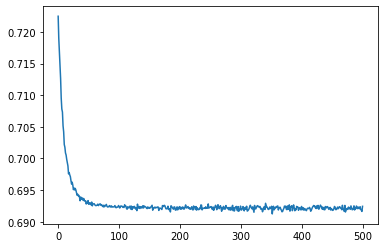

In [41]:
import matplotlib.pyplot as plt

plt.plot(train_cost)